In [18]:
import numpy as np
import scipy.optimize as opt
from scipy.stats import norm
from matplotlib import pyplot as plt
import pandas as pd
from NBinomRandomDataGenerator import NBinomRandomDataGenerator
import warnings

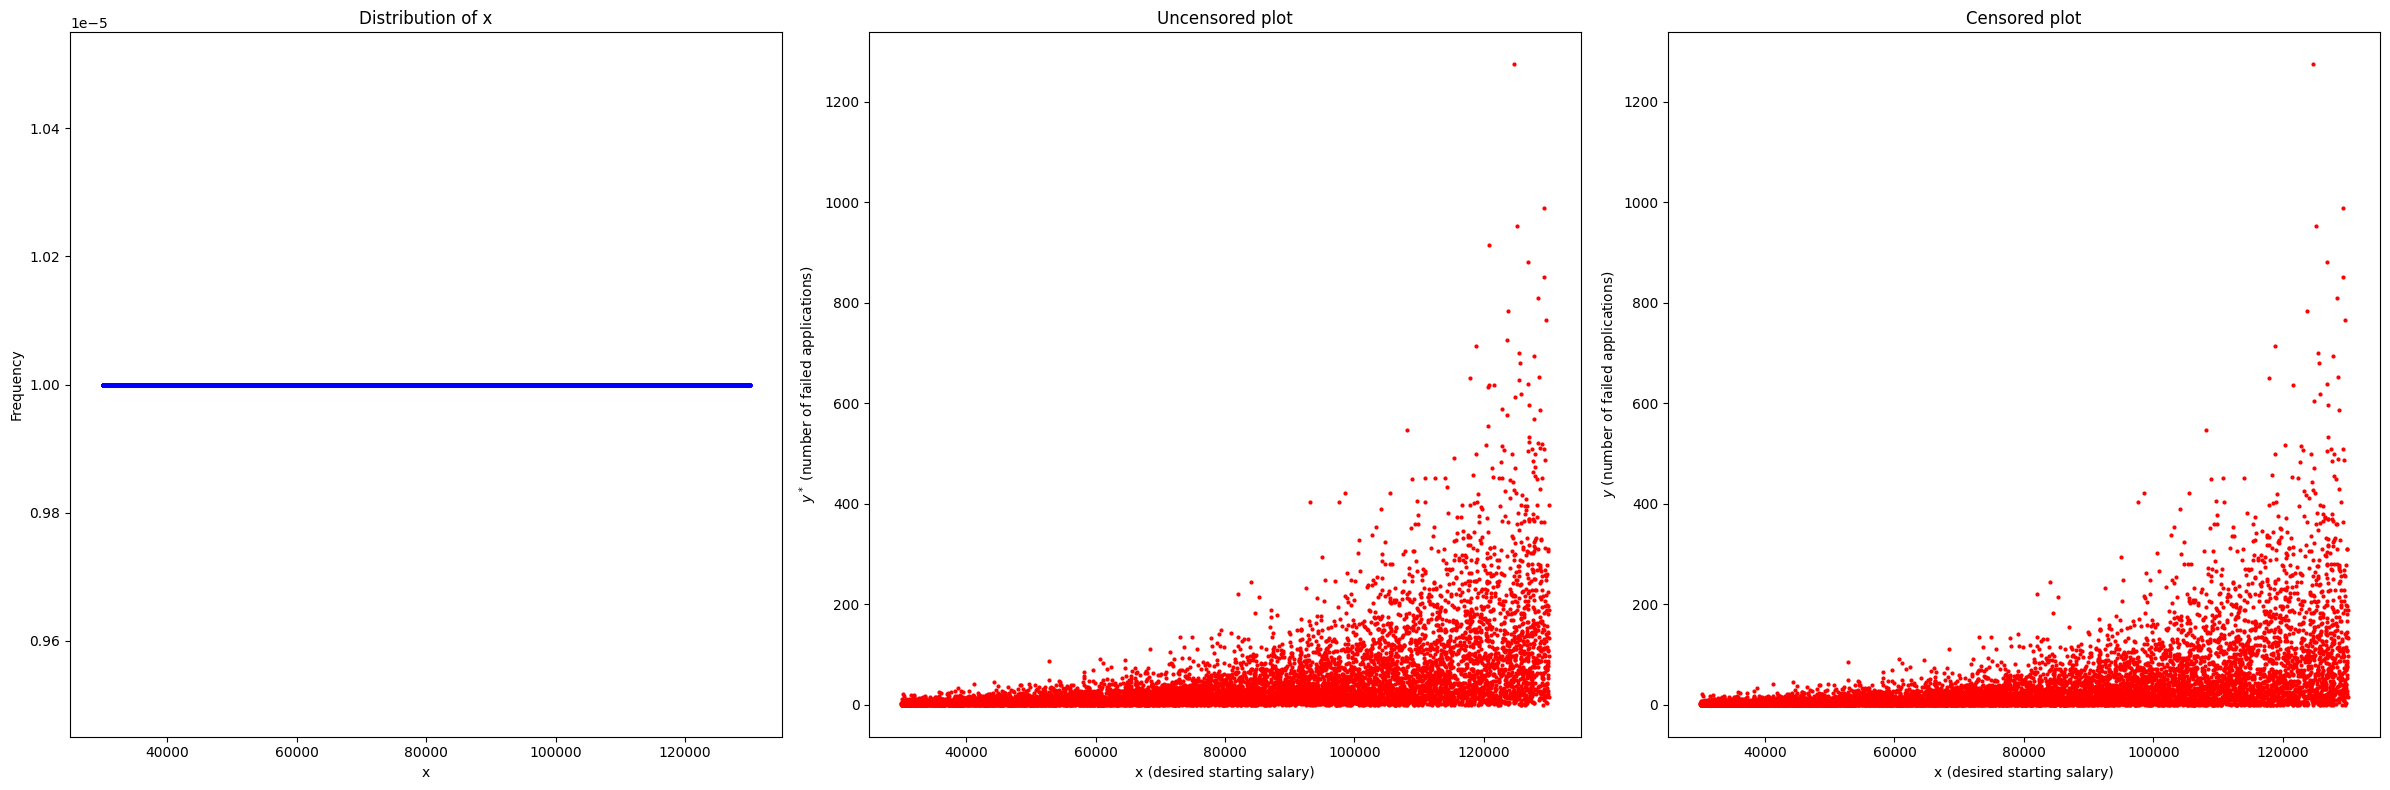

True beta value: [[ 0.e+00 -4.e-05]]


,Desired Starting Salary ($),Rejected Job Applications,Censored
0,57143,13,0
1,71573,22,0
2,52790,0,0
3,39475,1,1
4,37124,13,1
...,...,...,...
9995,31933,1,0
9996,110240,23,0
9997,82073,134,0
9998,115382,287,0


In [19]:
test1 = NBinomRandomDataGenerator(size=10000, x_distribution='uniform', beta=np.array([0, -4e-5]))
data = test1.createVaryingCensoredData(generate_plots=True)
print(f"True beta value: {test1.beta}")
data

In [20]:
# Organize data
x = data["Desired Starting Salary ($)"]
y = data["Rejected Job Applications"]
T = y.copy()
T[data['Censored'] == 0] = y + 1 # If there is no censoring, all that matters is T > y

In [21]:
def nbinom_likelihood(b, x, y, T):
    """x, y, T are numpy arrays or pandas series of length n"""

    def summation(p, T):
        return np.sum([((1-p)**a) * (p) for a in range(T)])

    xb = b[0] + b[1]*x
    p = (np.exp(xb) / (np.exp(xb) + 1)).fillna(1) # The fillna truncates overflow errors when xb is large
    
    sum = np.array([summation(pi, Ti) for pi, Ti in zip(p, T)])
    censored_point = (y == T).astype(int)
    Q = ((1-censored_point) * (np.log(p) + y * np.log(1-p))).fillna(0) +  (censored_point * np.log(1 - sum)).fillna(0) # nan's are filled with zeros, because it likely means that point isn't censored.

    out = -1*np.mean(Q)
    if np.isinf(out):
        out = 1e10
    return out

In [22]:
warnings.simplefilter('ignore')
bounds = ((-1, 1),(-1, 1))
# This minimizer works a lot better, but it's really sensitive to initial conditions. Also, b0 can be a bit off

sol = opt.differential_evolution(nbinom_likelihood, x0=np.array([0, -0.005]), bounds=bounds, args=(x, y, T), maxiter=int(1e12))
print(sol)
beta = sol.x
beta

             message: Optimization terminated successfully.
             success: True
                 fun: 3.1172322390652587
                   x: [-1.297e-01 -4.027e-05]
                 nit: 29
                nfev: 969
          population: [[-1.297e-01 -4.060e-05]
                       [ 2.259e-01 -4.350e-05]
                       ...
                       [-2.864e-01 -3.889e-05]
                       [ 1.322e-03 -4.110e-05]]
 population_energies: [ 3.117e+00  3.120e+00 ...  3.120e+00  3.118e+00]
                 jac: [-8.064e-03  2.200e+01]


array([-1.29684738e-01, -4.02650419e-05])

## Marginal Effects: True Distribution

In [23]:
def EV(b, x): # The expected value of Y, given beta and x
    return np.exp(-1*(b[0] + b[1]*x))

In [24]:
def d_EV(b,x):
    return -1*b[1] * EV(b=b, x=x)

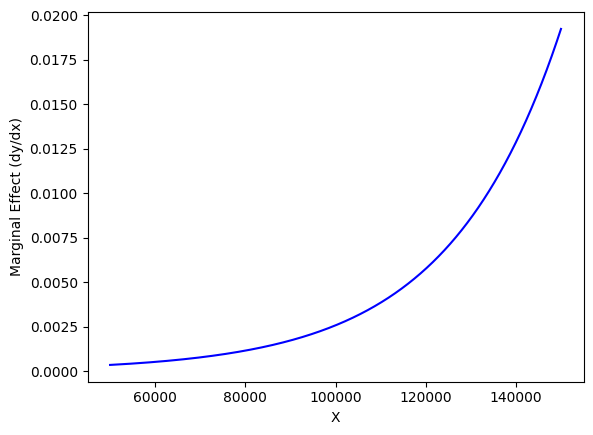

0        0.000343
1        0.000343
2        0.000343
3        0.000343
4        0.000343
           ...   
99995    0.019240
99996    0.019240
99997    0.019241
99998    0.019242
99999    0.019243
Length: 100000, dtype: float64

In [25]:
domain = pd.Series(np.arange(50000, 150000))

# plt.plot(domain, EV(beta, domain), 'b-')
plt.plot(domain, d_EV(beta, domain), 'b-')
plt.xlabel("X")
plt.ylabel("Marginal Effect (dy/dx)")

plt.show()
d_EV(beta, domain)

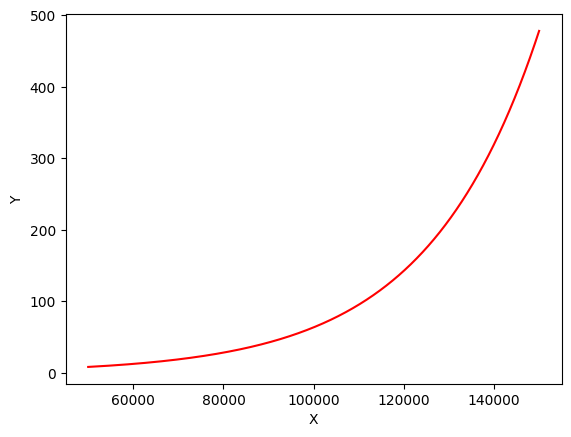

0        0.000343
1        0.000343
2        0.000343
3        0.000343
4        0.000343
           ...   
99995    0.019240
99996    0.019240
99997    0.019241
99998    0.019242
99999    0.019243
Length: 100000, dtype: float64

In [26]:
plt.plot(domain, EV(beta, domain), 'r-')
plt.xlabel("X")
plt.ylabel("Y")

plt.show()
d_EV(beta, domain)

## Marginal Effects: Tobit Model

In [27]:
def tobit_likelihood(b, x, y, T):
    """x, y, T are numpy arrays or pandas series of length n"""

    xb = b[1] + b[2]*x

    censored_point = (y == T).astype(int)
    Q = ((1-censored_point) * (np.log((1/b[0]) * norm.pdf((y - xb) / b[0])))).fillna(0) +  (censored_point * np.log(1 - norm.cdf((y - xb) / b[0]))).fillna(0) # nan's are filled with zeros, because it likely means that point isn't censored.

    out = -1*np.mean(Q)
    if np.isinf(out):
        out = 1e10
    return out


In [28]:
tobit_likelihood(b=np.array([100, 0.5, 1e-5]), x=x, y=y, T=T)

4.51732755320231

In [29]:
warnings.simplefilter('ignore')
bounds = ((0, 500),(-1, 1), (-1,1)) # TODO: What should these bounds even be?
# This minimizer works a lot better, but it's really sensitive to initial conditions. Also, b0 can be a bit off

sol = opt.differential_evolution(tobit_likelihood, x0=np.array([100, 0.5, 0.5]), bounds=bounds, args=(x, y, T), maxiter=int(1e12))
print(sol)
beta = sol.x
beta
# In this case I think the marginal effect is just b[2]?

             message: Optimization terminated successfully.
             success: True
                 fun: 4.214421185939671
                   x: [ 6.864e+01  4.017e-01  7.856e-04]
                 nit: 25
                nfev: 1206
          population: [[ 6.864e+01  4.017e-01  7.954e-04]
                       [ 7.601e+01  2.454e-01  3.513e-04]
                       ...
                       [ 7.312e+01  8.466e-01  9.210e-04]
                       [ 7.873e+01 -3.722e-01  8.619e-04]]
 population_energies: [ 4.214e+00  4.328e+00 ...  4.224e+00  4.221e+00]
                 jac: [-6.600e-04  1.074e-03  3.090e-02]


array([6.86404774e+01, 4.01667244e-01, 7.85564571e-04])